# Sensitivity and Uncertainty Analysis of HIV model_with_drugs

$\bullet$ $\bf{Uncertainty}$ $\bf{  analysis}$ may be used to assess the variability in the outcome variable that is due to the uncertainty in estimating the input values. May be performed by Latin Hypercube Sampling

$\bullet$ $\bf{Sensitivity}$ $\bf{  analysis}$ can extend an uncertainty analysis by identifying which parameters are important in contributing to the prediction imprecision (how do changes in the values of the input parameters alter the value of the outcome variable. May be performed by calculating partial rank correlation coefficient (PRCC) for each input parameter and outcome variable.

### Latin Hypercube Sampling

1) Define probability distribution functions for parameters and state variables

In [29]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import math
import random
from tqdm import tqdm

In [30]:
def hiv_expanded(x,t,s_1, s_2, s_3, p_1, p_2, S_1, S_2, k_1, k_2, k_3, k_4, k_5, k_6, k_7, k_8, k_9, k_10, k_11, k_12,\
                 delta_1, delta_2, delta_3, delta_4, delta_5, delta_6, delta_7, alpha_1, psi, fi, r, T_max, f_1, f_2,\
                 D_1, D_2, D_3, k_alpha_1, k_alpha_2, k_alpha_3, Cl_1, Cl_2,Cl_3,\
                 V_c1, V_c2, V_c3, F_1, F_2, F_3, IC_50_1,IC_50_2,IC_50_3, t_l, nu):


    
#     define system
    T=x[0]
    T_1=x[1]
    T_2=x[2]
    T_L1=x[3]
    T_L2=x[4]
    M=x[5]
    M_1=x[6]
    M_2=x[7]
    CTL=x[8]
    V_1=x[9]
    V_2=x[10]

    
    k_e1=Cl_1/V_c1
    k_e2=Cl_2/V_c2
    k_e3=Cl_3/V_c3
    C_1=F_1*D_1/V_c1*k_alpha_1/(k_alpha_1+k_e1)*(math.exp(-k_e1*(t-t_l))-math.exp(-k_alpha_1*(t-t_l)))
    C_2=F_2*D_2/V_c2*k_alpha_2/(k_alpha_2+k_e2)*(math.exp(-k_e2*(t-t_l))-math.exp(-k_alpha_2*(t-t_l)))
    C_3=F_3*D_3/V_c3*k_alpha_3/(k_alpha_1+k_e3)*(math.exp(-k_e3*(t-t_l))-math.exp(-k_alpha_3*(t-t_l)))
    u_1=((C_2/IC_50_2)+(C_3/IC_50_3))/(1+(C_2/IC_50_2)+(C_3/IC_50_3))
    u_2=C_1/(C_1+IC_50_1+0.001)
    
 

    dTdt=s_1+p_1*(V_1+V_2)*T/(V_1+V_2+S_1)-(1-u_1)*(k_1*V_1+k_2*M_1)*T-fi*(k_1*V_2+k_2*M_2)*T+\
    r*T*(1-(T+T_1+T_2+T_L1+T_L2)/T_max)-delta_1*T
    
    
    
    #latently infected LT1
    dT_L1dt=(1-u_1)*psi*(k_1*V_1+k_2*M_1)*T-alpha_1*T_L1-delta_3*T_L1
    dT_L2dt=(1-psi)*fi*(k_1*V_2+k_2*M_2)*T-alpha_1*T_L2-delta_3*T_L2
    
    
    #actively infected cells
    dT_1dt=(1-u_1)*psi*(k_1*V_1+k_2*M_1)*T+alpha_1*T_L1-delta_2*T_1-k_3*T_1*CTL
    dT_2dt=psi*fi*(k_1*V_2+k_2*M_2)*T+ alpha_1*T_L2-delta_2*T_2-k_3*T_2*CTL

    
    #macrophages
    dMdt=s_2+p_2*(V_1+V_2)*M/(V_1+V_2+S_2)-(1-f_1*u_1)*k_4*V_1*M-fi*k_4*V_2*M-delta_4*M
    dM_1dt=(1-f_1*u_1)*k_4*V_1*M-delta_5*M_1-k_5*M_1*CTL
    dM_2dt=fi*k_4*V_2*M-delta_5*M_2-k_5*M_2*CTL
    
    
    dCTLdt=s_3+k_6*(T_1+T_2)*CTL+k_7*(M_1+M_2)*CTL-delta_6*CTL
    
#     viruses
    dV_1dt=(1-u_2)*(1-nu)*k_8*T_1+(1-f_2*u_2)*(1-nu)*k_9*M_1+nu*fi*k_8*T_2+nu*fi*k_9*M_2-\
            (k_10*T+k_11*M)*V_1-k_12*V_1*M-delta_7*V_1
    dV_2dt=(1-u_2)*nu*k_8*T_1+(1-f_2*u_2)*nu*k_9*M_1+(1-nu)*fi*k_8*T_2+(1-nu)*fi*k_9*M_2-\
            (k_10*T+k_11*M)*V_2-k_12*V_2*M-delta_7*V_2

    
    return [dTdt, dT_1dt, dT_2dt, dT_L1dt, dT_L2dt, dMdt, dM_1dt,dM_2dt,dCTLdt, dV_1dt, dV_2dt]

In [31]:
# initial condition
x0 = [1000,0,0,0,0, 30,0,0,333, 0.001, 0]

# constants
s_1=10
s_2=0.15
s_3=5
p_1=0.16
p_2=0.15
S_1=55.6
S_2=188
k_1=0.00387
k_2=0.000001
k_3=0.00045
k_4=0.000522
k_5=0.000003
k_6=0.00033
k_7=0.000000006
k_8=0.537
k_9=0.285
k_10=0.00000779
k_11=0.000001  
k_12=0.00004
delta_1=0.02
delta_2=0.28
delta_3=0.05
delta_4=0.005
delta_5=0.005
delta_6=0.015
delta_7=2.39
alpha_1=0.0003
nu=0.001
psi=0.97
fi=0.9
f_1=0.34
f_2=0.34
T_max=1500

D_1=600
D_2=150
D_3=300
k_alpha_1=2.4
k_alpha_2=12
k_alpha_3=12
Cl_1=14800
Cl_2=560
Cl_3=2690
V_c1=28.7
V_c2=91
V_c3=112
F_1=1.0
F_2=0.86
F_3=0.64
IC_50_1=0.11
IC_50_2=0.34
IC_50_3=0.13
# drugs initiate at first moment t=0

r=0.03
t_l=0

In [32]:
# time points in days
t = np.linspace(0,100, 100)
# num of samples
n_samples=1000

In [33]:
def LHSu(x_min, x_max, n_samples):
    """Latin Hypercube Sampling from a uniform distribution
    Parameters:
    -----------
    x_min : minvalues
    x_max : maxvalues
    n_samples : n_ samples
    """
    lower_limits=np.arange(0, n_samples)/n_samples*(x_max-x_min)+x_min
    up_lim=np.arange(1, n_samples+1)/n_samples*(x_max-x_min)+x_min
    points=np.random.uniform(low=lower_limits, high=up_lim, size=[1, n_samples]).T
    np.random.shuffle(points)
    return points

Vary parameters and intial values for viruses(V(0)).

All parameters are uniform distributions with intervals of 10%

In [34]:
# TODO на случайной подвыборке параметров менять значения для увеличения точности алгоритма
# define  parameters limits
dict_with_parameters={
    's_1': [s_1-0.1*s_1, s_1+0.1*s_1],
    's_2': [s_2-0.1*s_2, s_2+0.1*s_2],
    's_3':[s_3-0.1*s_3, s_3+0.1*s_3],
    'p_1':[p_1-0.1*p_1, p_1+0.1*p_1],
    'p_2':[p_2-0.1*p_2, p_2+0.1*p_2],
    'S_1':[S_1-0.1*S_1, S_1+0.1*S_1],
    'S_2':[S_2-0.1*S_2, S_2+0.1*S_2],
    'k_1':[k_1-0.1*k_1, k_1+0.1*k_1],
    'k_2':[k_2-0.1*k_2, k_2+0.1*k_2],
    'k_3':[k_3-0.1*k_3, k_3+0.1*k_3],
    'k_4':[k_4-0.1*k_4, k_4+0.1*k_4],
    'k_5':[k_5-0.1*k_5, k_5+0.1*k_5],
    'k_6':[k_6-0.1*k_6, k_6+0.1*k_6], 
    'k_7':[k_7-0.1*k_7, k_7+0.1*k_7],
    'k_8':[k_8-0.1*k_8, k_8+0.1*k_8],
    'k_9':[k_9-0.1*k_9, k_9+0.1*k_9],
    'k_10':[k_10-0.1*k_10, k_10+0.1*k_10],
    'k_11':[k_11-0.1*k_11, k_11+0.1*k_11],
    'k_12':[k_12-0.1*k_12, k_12+0.1*k_12],
    'delta_1':[delta_1-0.1*delta_1, delta_1+0.1*delta_1],
    'delta_2':[delta_2-0.1*delta_2, delta_2+0.1*delta_2],
    'delta_3':[delta_3-0.1*delta_3, delta_3+0.1*delta_3],
    'delta_4':[delta_4-0.1*delta_4, delta_4+0.1*delta_4],
    'delta_5':[delta_5-0.1*delta_5, delta_5+0.1*delta_5],
    'delta_6':[delta_6-0.1*delta_6, delta_6+0.1*delta_6],
    'delta_7':[delta_7-0.1*delta_7, delta_7+0.1*delta_7],
    'alpha_1':[alpha_1-0.1*alpha_1, alpha_1+0.1*alpha_1],
    'psi':[0.93, 0.98],
    'fi':[0.1, 0.9],
    'r':[0.027,0.033 ],
    'T_max':[1450, 1650],
    'f_1':[0.335,0.345],
    'f_2':[0.335,0.345],
    'D_1':[540, 640],
    'D_2':[135, 165],
    'D_3':[270, 330],
    'k_alpha_1':[2.38, 2.42],
    'k_alpha_2':[11,13],
    'k_alpha_3':[11,13],
    'Cl_1':[14652,14948],
    'Cl_2':[490, 600],
    'Cl_3':[24, 28],
    'V_c1':[26, 30],
    'V_c2':[80, 100],
    'V_c3':[10,12],
    'F_1':[0.99,1.1],
    'F_2':[0.78, 0.94],
    'F_3':[0.58, 0.7],
    'IC_50_1':[0.1, 0.12],
    'IC_50_2':[0.31,0.37],
    'IC_50_3':[0.12,0.14],
    'nu':[0.0009, 0.0011],
    'V(0)':[0.0009, 0.0011]    
}
    


In [35]:
variable_list=[i for i in dict_with_parameters.keys()]

In [36]:
dict_with_parameters.keys()

dict_keys(['s_1', 's_2', 's_3', 'p_1', 'p_2', 'S_1', 'S_2', 'k_1', 'k_2', 'k_3', 'k_4', 'k_5', 'k_6', 'k_7', 'k_8', 'k_9', 'k_10', 'k_11', 'k_12', 'delta_1', 'delta_2', 'delta_3', 'delta_4', 'delta_5', 'delta_6', 'delta_7', 'alpha_1', 'psi', 'fi', 'r', 'T_max', 'f_1', 'f_2', 'D_1', 'D_2', 'D_3', 'k_alpha_1', 'k_alpha_2', 'k_alpha_3', 'Cl_1', 'Cl_2', 'Cl_3', 'V_c1', 'V_c2', 'V_c3', 'F_1', 'F_2', 'F_3', 'IC_50_1', 'IC_50_2', 'IC_50_3', 'nu', 'V(0)'])

In [37]:
a=LHSu(dict_with_parameters['s_1'][0], dict_with_parameters['s_1'][1],4) #return 4 samples of parameter s_1
a

array([[10.29249393],
       [ 9.47843485],
       [ 9.51540028],
       [10.91236804]])

In [38]:
print ("num of parameters", len(variable_list))

num of parameters 53


In [39]:
# define parameters which we want vary
params=[]
for i  in variable_list:
    params.append(LHSu(dict_with_parameters[i][0], dict_with_parameters[i][1],n_samples))

In [40]:
# solve ODE
T=[]
T_1=[]
T_2=[]
T_L1=[]
T_L2=[]
M=[]
M_1=[]
M_2=[]
CTL=[]
V_1=[]
V_2=[]
cumulative_V=[]
# LHS matrix
X_matrix=[]
for i in tqdm(range(n_samples)):
    parameters=[float(j[i]) for j in params]
    x0 = [1000,0,0,0,0, 30,0,0,333, float(parameters[-1]), 0]   
    x = odeint(hiv_expanded, x0, t, args=(*parameters[0:51],t_l,parameters[51] ))   
    X_matrix.append(parameters)
    
    # get solution
    T.append(x[:,0])
    T_1.append(x[:,1])
    T_2.append(x[:,2])
    T_L1.append(x[:,3])
    T_L2.append(x[:,4])
    M.append(x[:,5])
    M_1.append(x[:,6])
    M_2.append(x[:,7])
    CTL.append(x[:,8])
    V_1.append(x[:,9])
    V_2.append(x[:,10])
#     cumulativa reward
    cumulative_V.append(x[:,9]+x[:, 10])


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 27.96it/s]


In [26]:
# get list from it
values=[]
values=[T,T_1, T_2, T_L1, T_L2, M, M_1, M_2, CTL, V_1, V_2, cumulative_V]
titles=['healthy T4 cells', 'latently_infected_by wild type T4 cells', 'latently_infected_by mutated type T4 cells', \
        'actively_infected_by wild type T4 cells', 'actively_infected_by mutated type T4 cells', \
        'healthy macrophages', 'infected by wild-type macrophages',  'infected by mutated-type macrophages',\
        'cytotoxic cells', 'wild type virus', 'mutated type virus', 'cumulative_viruses']

In [41]:
len(cumulative_V)

1000

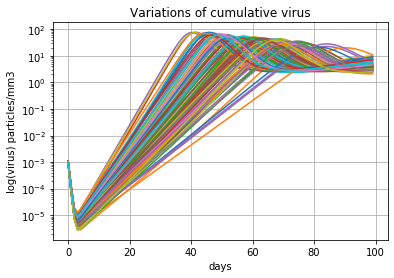

In [47]:
plt.title('Variations of cumulative virus')
for i in range(100):
    plt.semilogy(cumulative_V[i])
plt.xlabel('days')
plt.ylabel('log(virus) particles/mm3')
plt.grid()
plt.show()

In [49]:
# check if there are some some solutions that are not good
np_nan=[]
for  i in range(len(cumulative_V)):
    if np.isnan(cumulative_V[i].max()):
        np_nan.append(i)
print(np_nan)
cumulative_V = [i for j, i in enumerate(cumulative_V) if j not in np_nan]
for i in range (len(params)):
    params[i]=np.delete(params[i], np_nan)        

[]


Search for point of minimazing viral load for each virus sample

In [53]:

V_min_for_each_set=[]
nan_indexes=[]
for  i in range(len(cumulative_V)):
    if np.isnan(cumulative_V[i].max()==True):
        nan_indexes.append(i)
    index_max_element=np.where(cumulative_V[i]==cumulative_V[i].max())[0][0]
    indices = np.where(cumulative_V[i][index_max_element:] == cumulative_V[i][index_max_element:].min())
#     indexes of minimum viral load for each sample
    V_min_for_each_set.append(int(indices[0][0])+index_max_element)

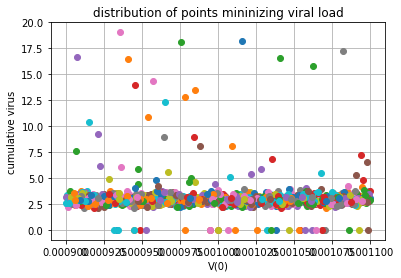

In [58]:
for i in range(len(cumulative_V)):
    num=V_min_for_each_set[i]
    plt.plot(params[-1][i], cumulative_V[i][num],'o')
plt.xlabel('V(0)')
plt.ylabel('cumulative virus')
plt.title('distribution of points mininizing viral load')  
plt.grid()
plt.show()

In [59]:
Y_matrix=[]
for i in range(len(cumulative_V)):
    num=V_min_for_each_set[i]
    Y_matrix.append(cumulative_V[i][num])

In [60]:
X_matrix = [i for j, i in enumerate(X_matrix) if j not in np_nan]

In [61]:
X = pd.DataFrame()
num_parameters=len(X_matrix[0])
for i in range(num_parameters):
    column=[X_matrix[j][i] for j in range(len(X_matrix))]
    X[variable_list[i]]=column

In [62]:
variable_list

['s_1',
 's_2',
 's_3',
 'p_1',
 'p_2',
 'S_1',
 'S_2',
 'k_1',
 'k_2',
 'k_3',
 'k_4',
 'k_5',
 'k_6',
 'k_7',
 'k_8',
 'k_9',
 'k_10',
 'k_11',
 'k_12',
 'delta_1',
 'delta_2',
 'delta_3',
 'delta_4',
 'delta_5',
 'delta_6',
 'delta_7',
 'alpha_1',
 'psi',
 'fi',
 'r',
 'T_max',
 'f_1',
 'f_2',
 'D_1',
 'D_2',
 'D_3',
 'k_alpha_1',
 'k_alpha_2',
 'k_alpha_3',
 'Cl_1',
 'Cl_2',
 'Cl_3',
 'V_c1',
 'V_c2',
 'V_c3',
 'F_1',
 'F_2',
 'F_3',
 'IC_50_1',
 'IC_50_2',
 'IC_50_3',
 'nu',
 'V(0)']

In [66]:
print('matrix of values')

X

matrix of values


,s_1,s_2,s_3,p_1,p_2,S_1,S_2,k_1,k_2,k_3,...,V_c2,V_c3,F_1,F_2,F_3,IC_50_1,IC_50_2,IC_50_3,nu,V(0)
0,9.040237,0.152640,4.817691,0.157617,0.158766,57.024351,206.037105,0.003757,9.973008e-07,0.000416,...,88.313167,11.651923,1.002112,0.801495,0.620215,0.114821,0.366079,0.133482,0.001014,0.000932
1,10.756622,0.157956,4.772320,0.165560,0.159315,54.049115,183.148905,0.004043,1.002962e-06,0.000493,...,91.959856,11.044980,1.073827,0.891984,0.689097,0.106666,0.345146,0.136992,0.001085,0.001009
2,9.195660,0.161882,4.537839,0.162526,0.138626,51.167096,198.558636,0.003693,1.091190e-06,0.000441,...,80.460899,11.054147,1.068039,0.887848,0.650511,0.107822,0.321513,0.124152,0.000948,0.001015
3,9.972072,0.155330,5.071913,0.166889,0.155069,51.742560,180.226684,0.004176,1.021575e-06,0.000435,...,88.239685,11.057998,1.082189,0.895403,0.662055,0.106902,0.365515,0.138432,0.001072,0.000985
4,9.080075,0.138653,4.676847,0.156096,0.144123,56.694740,179.621944,0.003904,9.429615e-07,0.000475,...,86.940635,11.197440,1.060315,0.932444,0.668275,0.112000,0.356573,0.126372,0.001074,0.001083
5,9.877893,0.136620,5.015505,0.148592,0.140494,55.507568,183.037630,0.004154,1.069213e-06,0.000469,...,84.039670,10.158235,1.047003,0.914327,0.656546,0.111494,0.318396,0.128655,0.001044,0.000984
6,9.498269,0.161394,4.882616,0.152389,0.149558,57.911660,178.962247,0.004245,1.007559e-06,0.000425,...,88.758236,11.380938,1.050190,0.871635,0.627848,0.109115,0.312926,0.134151,0.001016,0.000944
7,9.173895,0.142840,5.334711,0.145514,0.161399,55.252522,197.117959,0.003671,9.918093e-07,0.000495,...,81.677734,11.765145,1.084053,0.898168,0.605050,0.110611,0.342484,0.126744,0.001098,0.001005
8,10.690759,0.142327,5.056504,0.174646,0.157139,56.653806,188.791535,0.003863,9.405366e-07,0.000416,...,95.921821,10.805444,1.068782,0.794000,0.596401,0.107597,0.312387,0.124069,0.001032,0.000918
9,9.779216,0.164615,4.699545,0.147302,0.140459,52.927084,174.046144,0.004130,9.099540e-07,0.000494,...,96.604428,11.772614,0.998996,0.936606,0.627973,0.105787,0.324499,0.130186,0.001074,0.001060


### Full matrix

In [67]:
X.shape

(1000, 53)

In [68]:
full_matrix=X
full_matrix['V_min']=Y_matrix

In [69]:
full_matrix.head()

,s_1,s_2,s_3,p_1,p_2,S_1,S_2,k_1,k_2,k_3,...,V_c3,F_1,F_2,F_3,IC_50_1,IC_50_2,IC_50_3,nu,V(0),V_min
0,9.040237,0.152640,4.817691,0.157617,0.158766,57.024351,206.037105,0.003757,9.973008e-07,0.000416,...,11.651923,1.002112,0.801495,0.620215,0.114821,0.366079,0.133482,0.001014,0.000932,2.752506
1,10.756622,0.157956,4.772320,0.165560,0.159315,54.049115,183.148905,0.004043,1.002962e-06,0.000493,...,11.044980,1.073827,0.891984,0.689097,0.106666,0.345146,0.136992,0.001085,0.001009,2.660202
2,9.195660,0.161882,4.537839,0.162526,0.138626,51.167096,198.558636,0.003693,1.091190e-06,0.000441,...,11.054147,1.068039,0.887848,0.650511,0.107822,0.321513,0.124152,0.000948,0.001015,2.937349
3,9.972072,0.155330,5.071913,0.166889,0.155069,51.742560,180.226684,0.004176,1.021575e-06,0.000435,...,11.057998,1.082189,0.895403,0.662055,0.106902,0.365515,0.138432,0.001072,0.000985,3.152146
4,9.080075,0.138653,4.676847,0.156096,0.144123,56.694740,179.621944,0.003904,9.429615e-07,0.000475,...,11.197440,1.060315,0.932444,0.668275,0.112000,0.356573,0.126372,0.001074,0.001083,2.794832


### PRCC

In [84]:
from scipy.stats import rankdata
from scipy import stats 

In [85]:
from sklearn import linear_model
def calculate_partial_correlation(input_df):
    """
    Returns the sample linear partial correlation coefficients between pairs of variables,
    controlling for all other remaining variables

    Parameters
    ----------
    input_df : array-like, shape (n, p)
        Array with the different variables. Each column is taken as a variable.

    Returns
    -------
    P : array-like, shape (p, p)
        P[i, j] contains the partial correlation of input_df[:, i] and input_df[:, j]
        controlling for all other remaining variables.
    """
    partial_corr_matrix = np.zeros((input_df.shape[1], input_df.shape[1]));
    for i, column1 in enumerate(input_df):
        for j, column2 in enumerate(input_df):
            control_variables = np.delete(np.arange(input_df.shape[1]), [i, j]);
            if i==j:
                partial_corr_matrix[i, j] = 1;
                continue
            data_control_variable = input_df.iloc[:, control_variables]
            data_column1 = input_df[column1].values
            data_column2 = input_df[column2].values
            fit1 = linear_model.LinearRegression(fit_intercept=True)
            fit2 = linear_model.LinearRegression(fit_intercept=True)
            fit1.fit(data_control_variable, data_column1)
            fit2.fit(data_control_variable, data_column2)
            residual1 = data_column1 - (np.dot(data_control_variable, fit1.coef_) + fit1.intercept_)
            residual2 = data_column2 - (np.dot(data_control_variable, fit2.coef_) + fit2.intercept_)
            partial_corr_matrix[i,j] = stats.pearsonr(residual1, residual2)[0]
    return pd.DataFrame(partial_corr_matrix, columns = input_df.columns, index = input_df.columns)

In [78]:
ranked_full_matrix= pd.DataFrame()
num_parameters=len(X_matrix[0])
for i in range(num_parameters):
    column=[X_matrix[j][i] for j in range(len(X_matrix))]
    column=rankdata(column)
    ranked_full_matrix[variable_list[i]]=column
ranked_full_matrix['V_min']=rankdata(Y_matrix)

In [81]:
def show_gistogram(cor, save, title):
    x = np.arange(cor['V_min'].count())
    y = cor.sort_values(by=['V_min'], ascending=False)['V_min']
    fig, ax = plt.subplots()
    position = np.arange(cor['V_min'].count())
    ax.barh(position, y)
    plt.title(title)
    ax.set_facecolor('seashell')
    ax.set_ylabel('parameters',fontsize = 20)
    ax.set_yticks(position)
    ax.set_yticklabels(list(cor.sort_values(by=['V_min'], ascending=False).index))
    fig.set_facecolor('floralwhite')
    fig.set_figwidth(18)    #  ширина Figure
    fig.set_figheight(14)    #  высота Figure
    plt.savefig(save)
    plt.show()

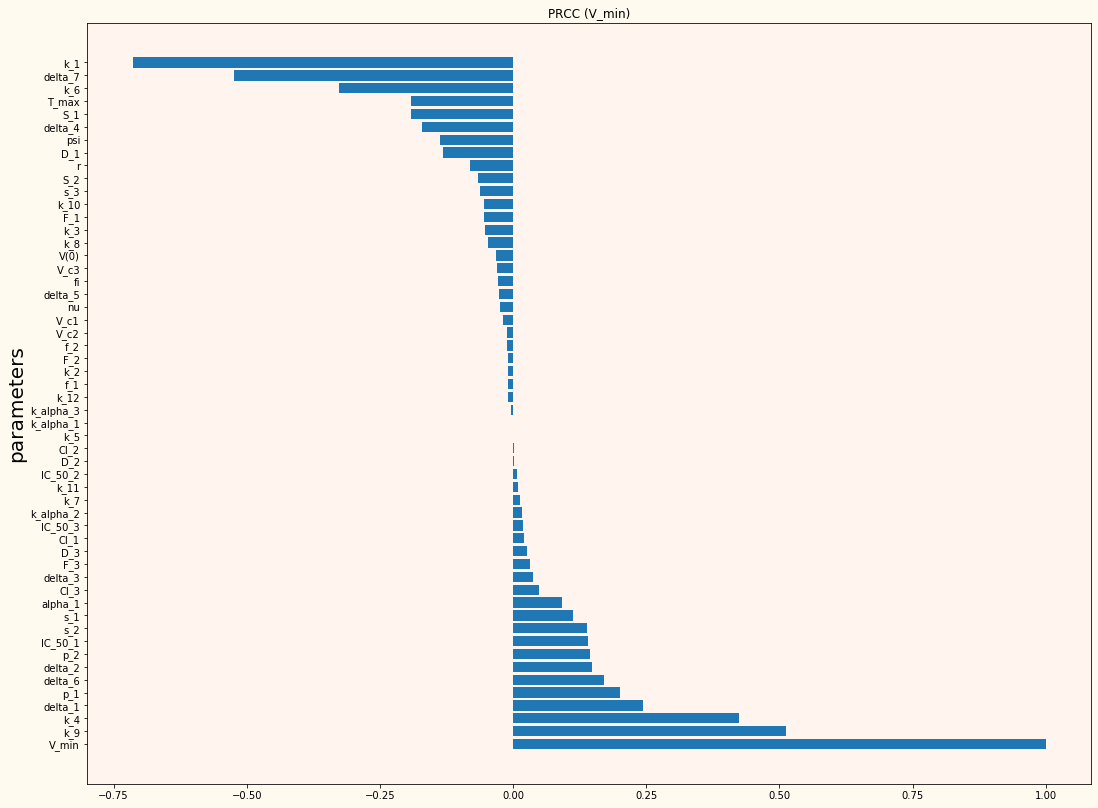

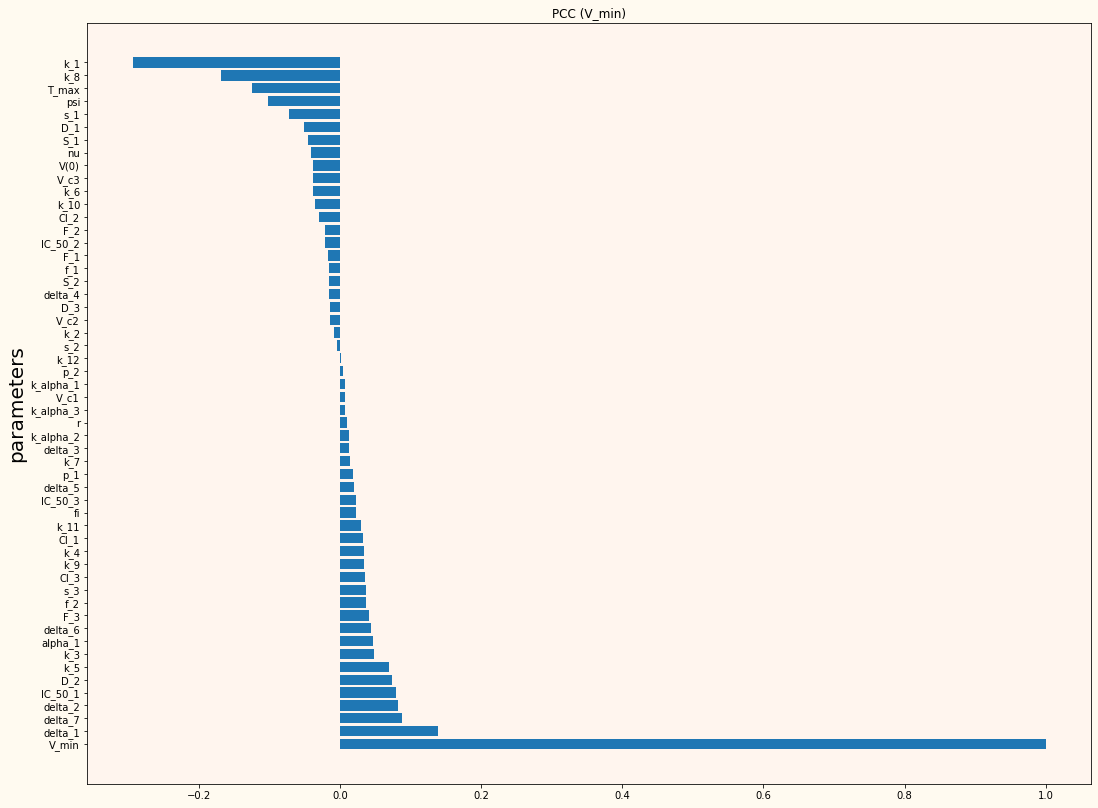

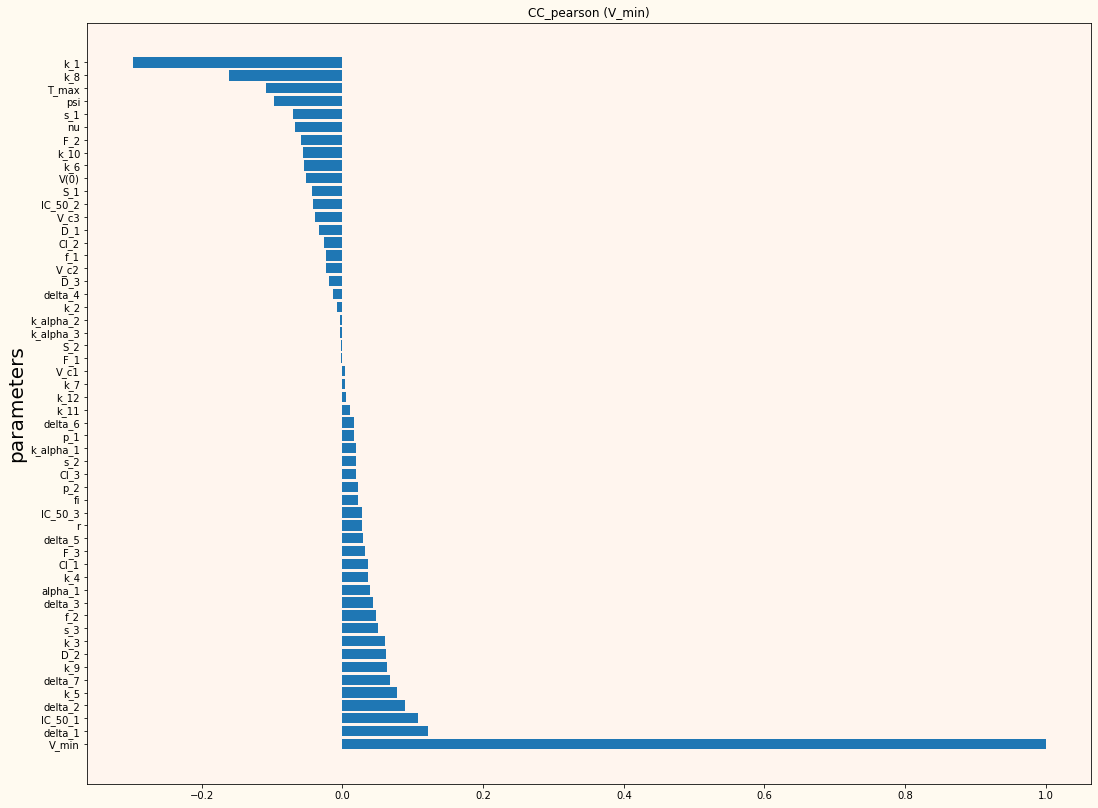

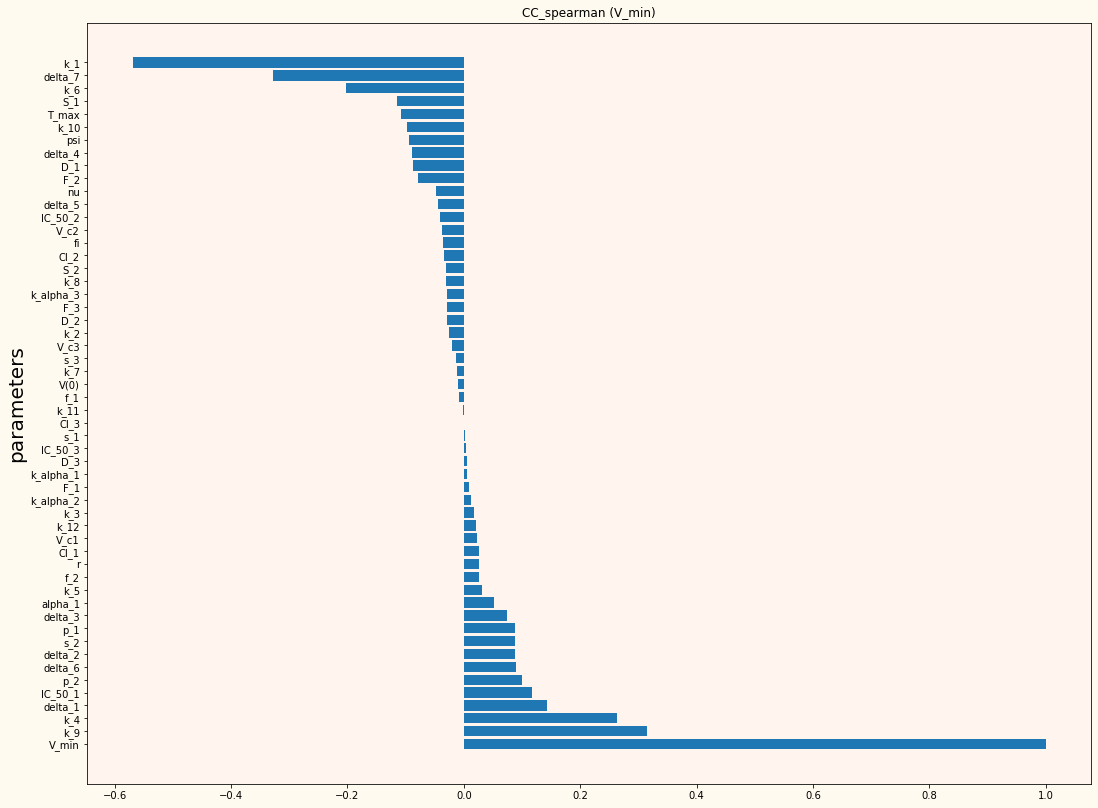

In [82]:
cor=calculate_partial_correlation(ranked_full_matrix)
show_gistogram(cor, 'PRCC.png', 'PRCC (V_min)')
cor=calculate_partial_correlation(full_matrix)
show_gistogram(cor, 'PCC.png', 'PCC (V_min)')
cor=full_matrix.corr(method='pearson')
show_gistogram(cor, 'CC_pearson.png', 'CC_pearson (V_min)')
cor=full_matrix.corr(method='spearman')
show_gistogram(cor, 'CC_spearman.png', 'CC_spearman (V_min)')

Built heat map for PRCC

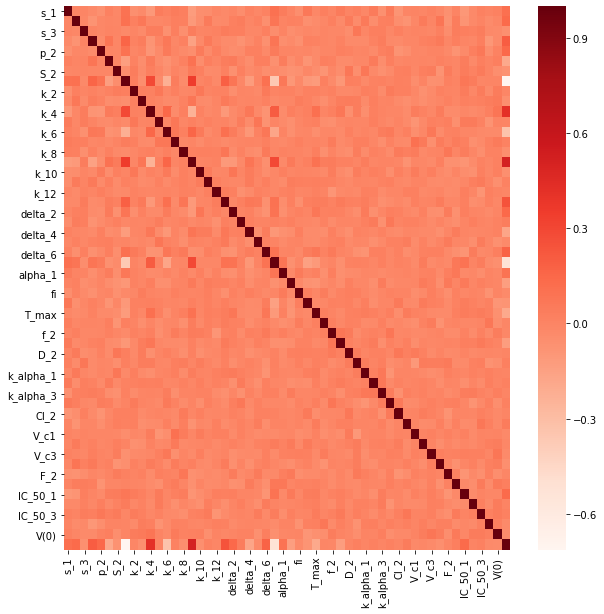

In [87]:
import seaborn as sns
plt.figure(figsize=(10,10))
cor=calculate_partial_correlation(ranked_full_matrix)
sns.heatmap(cor,  cmap=plt.cm.Reds)
plt.show()